In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [62]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "v25_e",
    "model_tag":       "
    
    ",
    "samples_version": "v5",
    "cols": [
        "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        #"PuppiMET_pt",
        ###"vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        "vjet_1_pt",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "deltaeta_vjet",
        "deltaphi_vjet",
        #"deltaR_lep_vbs",
        #"deltaphi_lep_nu",
        #"deltaR_vbs",
        #"deltaR_vjet",
        ##"Zvjets_0",
        #"Zvjets_1",
        "Zlep",
        ####"Asym_vbs",
        #"Mtw_lep",
        #"w_had_pt",
        #"R_mw",
        #"A_ww",
        "Centr_vbs",
        "Centr_ww",
        "vbs_0_qglmorphed_res",
        #"vbs_1_qgl_res",
        "vjet_0_qglmorphed_res",
        "vjet_1_qglmorphed_res",
        #"four_tag_jets_HT",
        #"four_tag_jets_pt",
        #"vbs_jets_HT", 
        #"v_jets_HT",
        #"vbs_jets_pt"
        #"cosdeltatheta_Vhad",
        #"cosdeltatheta_vjet_0",
        ],    
    "test_size": 0.15,
    "val_size":  0.0,
    "random_seed": 45,
    "optimizer": "adam",
    "batch_size": 64,
    "decay_weights":  'inverse', #or cyclic
    "decay_weights_pars" : [1e-5,3,0.3], #[0.00005, 0.001, 15000] 
    "patience": [5,0.002]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [5]:
len(config["cols"])

18

In [47]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [7]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [67]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

## Modify weight for training

In [68]:
W_mjj = (X[:,config["cols"].index('mjj_vbs')]<1500) + ((X[:,config["cols"].index('mjj_vbs')]>=1500)*X[:,config["cols"].index('mjj_vbs')]*2/1500)

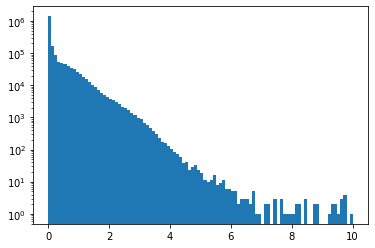

In [32]:
plt.hist(W, range=(0,10),bins=100)
plt.yscale('log')

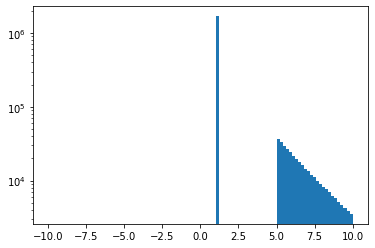

In [33]:
plt.hist(W_mjj, range=(-10,10),bins=100)
plt.yscale('log')

In [69]:
# Apply the weight
W = W* W_mjj

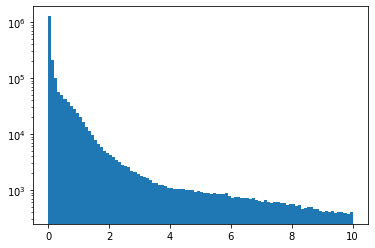

In [35]:
plt.hist(W, range=(0,10),bins=100)
plt.yscale('log')

In [70]:
(W[Y==1].sum())/(W[Y==0].sum())

1.387968651632169

# Variables

In [26]:
wjets = scaler.transform(bkg[bkg.sample_name=="Wjets_HT"][config["cols"]].values)
dy =scaler.transform(bkg[bkg.sample_name=="DY"][config["cols"]].values)
top = scaler.transform(bkg[bkg.sample_name=="top"][config["cols"]].values)

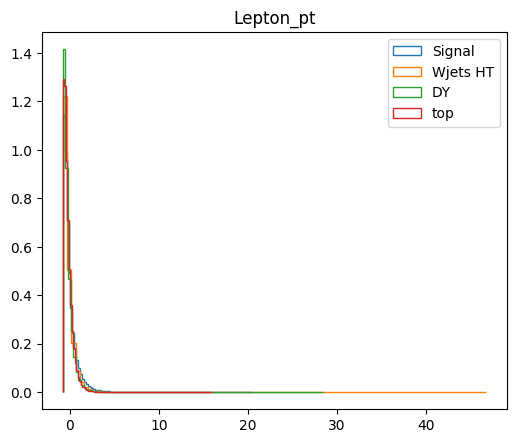

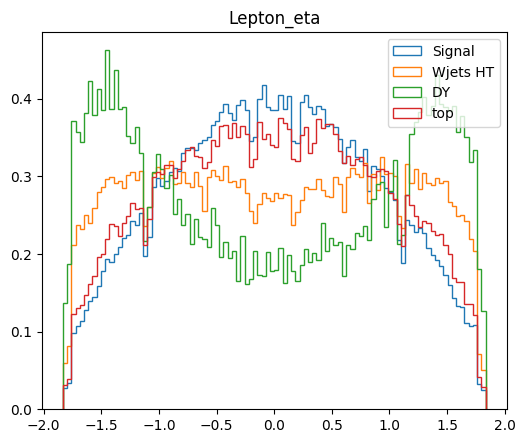

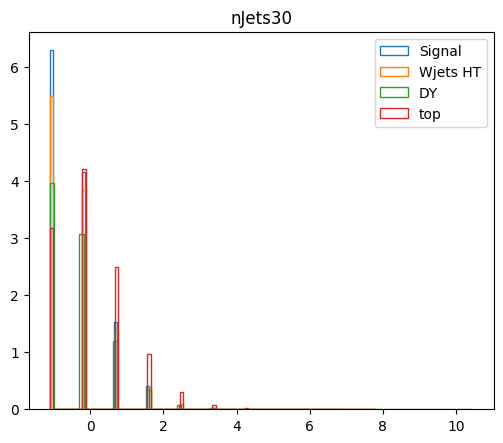

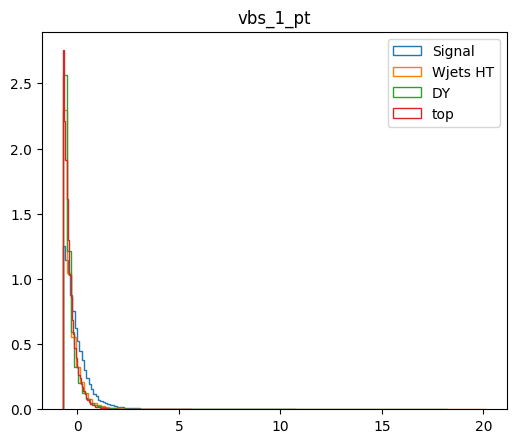

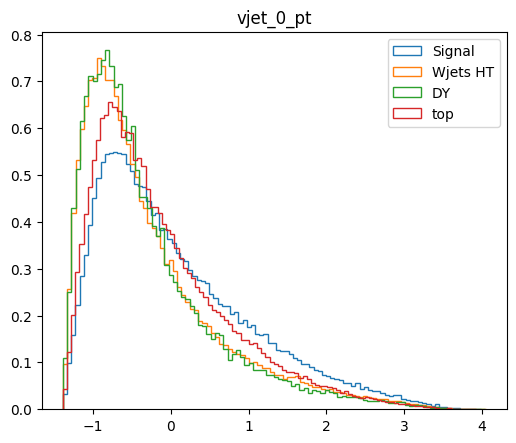

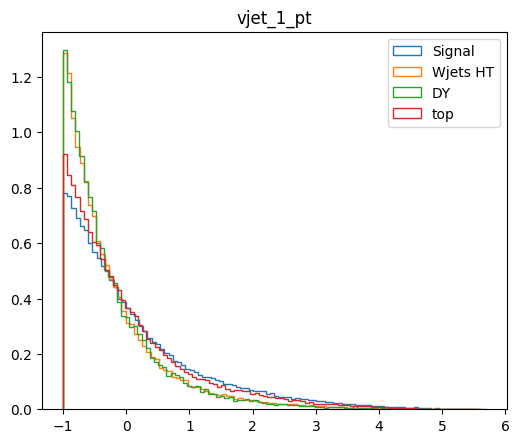

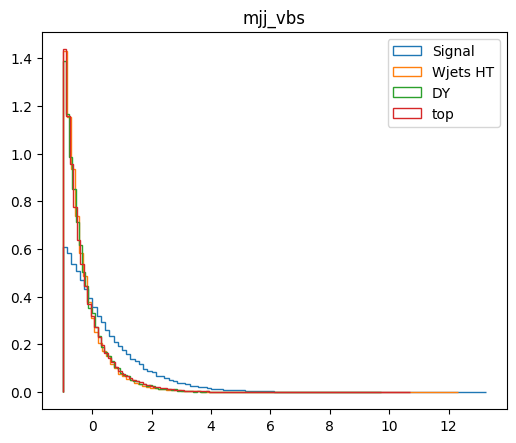

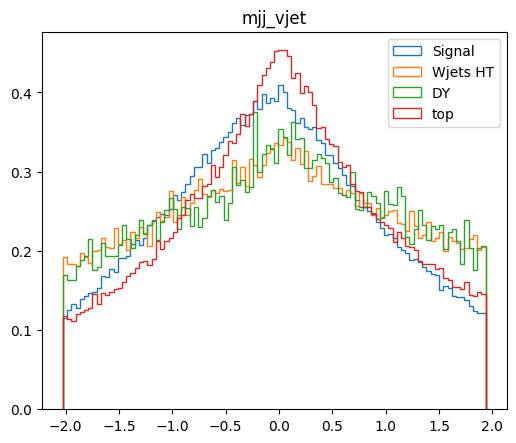

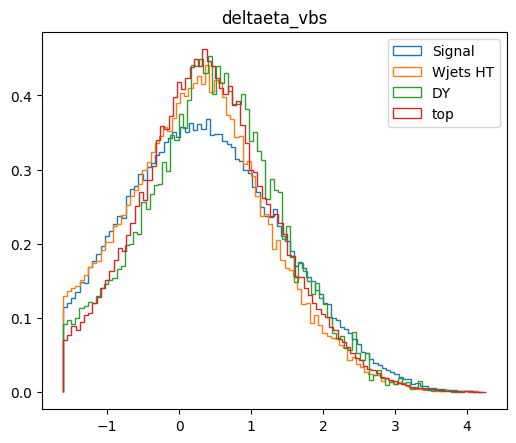

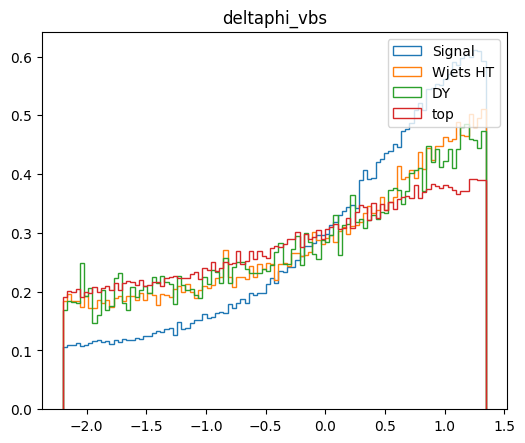

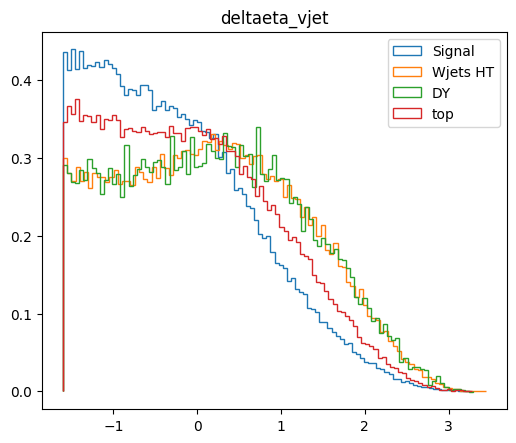

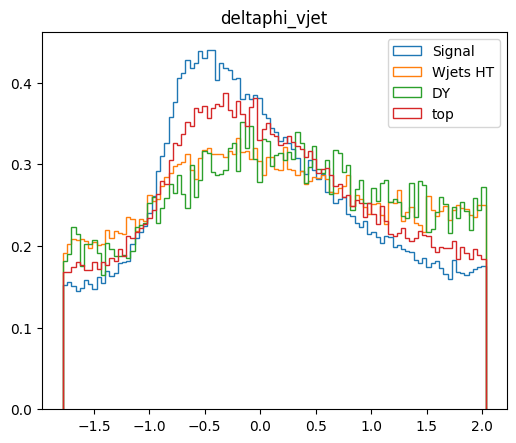

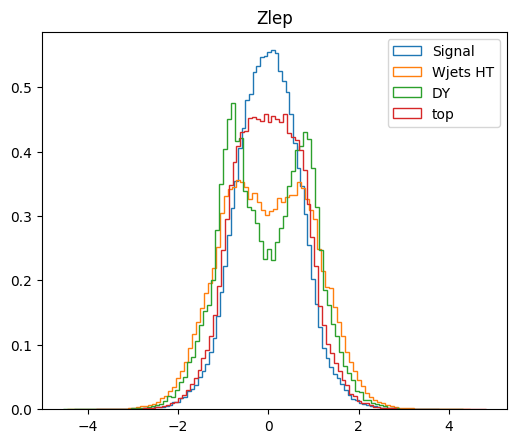

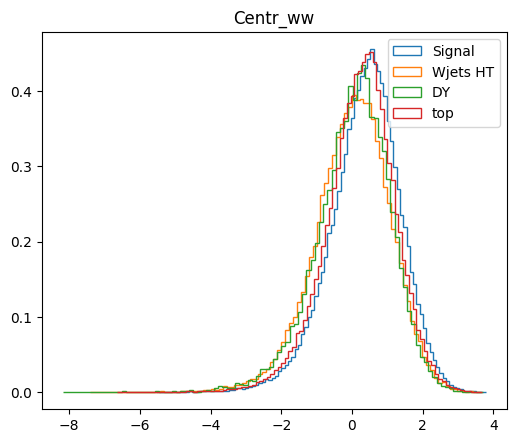

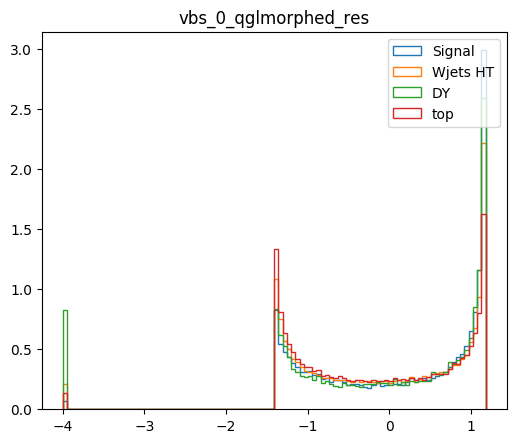

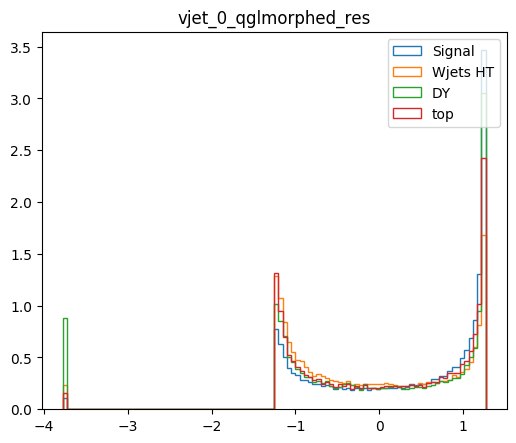

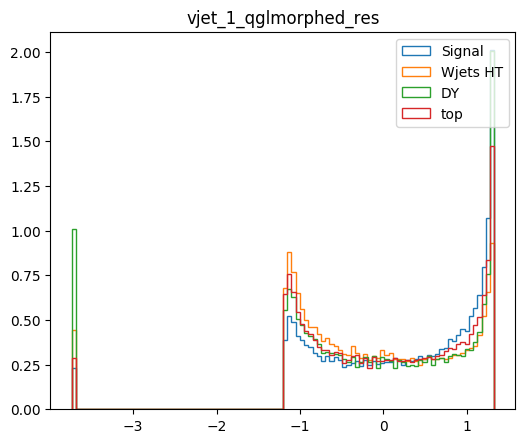

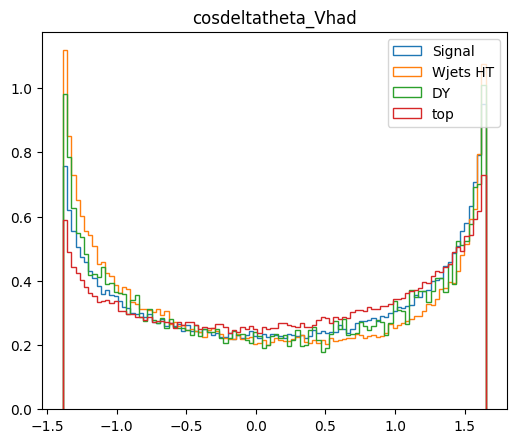

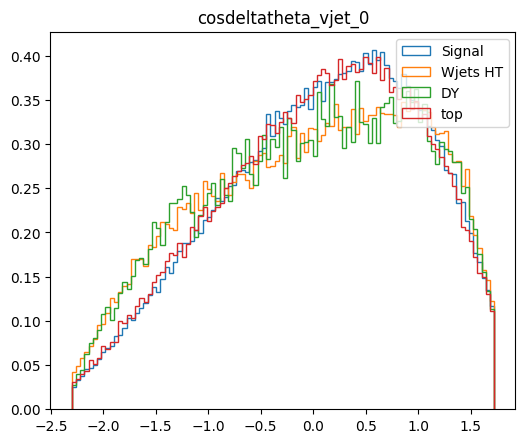

In [28]:
## draw weights and input variables in order to spot any importing error

for idx,col in enumerate(config["cols"]):
    fig = plt.figure(figsize=(6,5), dpi=100)
    _ = plt.hist(X_scaled[Y==1,idx], weights=Wnn[Y==1]  , bins=100, histtype="step", density=True, label="Signal")
    _ = plt.hist(wjets[:,idx], weights=bkg[bkg.sample_name=="Wjets_HT"]["weight"], bins=100, histtype="step", density=True, label="Wjets HT")
    _ = plt.hist(dy[:,idx], weights=bkg[bkg.sample_name=="DY"]["weight"], bins=100, histtype="step", density=True, label="DY")
    _ = plt.hist(top[:,idx],weights=bkg[bkg.sample_name=="top"]["weight"], bins=100, histtype="step", density=True, label="top")
    plt.legend()
    plt.title(col)
    plt.show()

##  Balancing


In [71]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"],
                             random_state=config["random_seed"], stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val


In [54]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (1758820, 18)
Test + Val dataset:  (310380, 18)


Create generators to balance signal and background

## Keras model

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# import local module that programmatically returns keras models
import tensorflow as tf


In [72]:
import dnn_models_v2

print(config["model_tag"])
model = dnn_models_v2.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss="binary_crossentropy",
            metrics=['accuracy'])

model.summary()

4l_triangle128_64_l2_batchnorm_relu
>>> Creating model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               2432      
_________________________________________________________________
activation_19 (Activation)   (None, 128)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_20 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
______________________________________________________________

In [73]:
## import and configure the plot loss callback

import dnn_training_logger

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_test, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test!= val
    "y_val" : y_test, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_test, ## test == val
    
    "Wnn_train": Wnn_train,

    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_test, ## test == val
}

plot_losses = dnn_training_logger.TrainingLogger(model, data, dnncut=0.80, batch_mode=False)

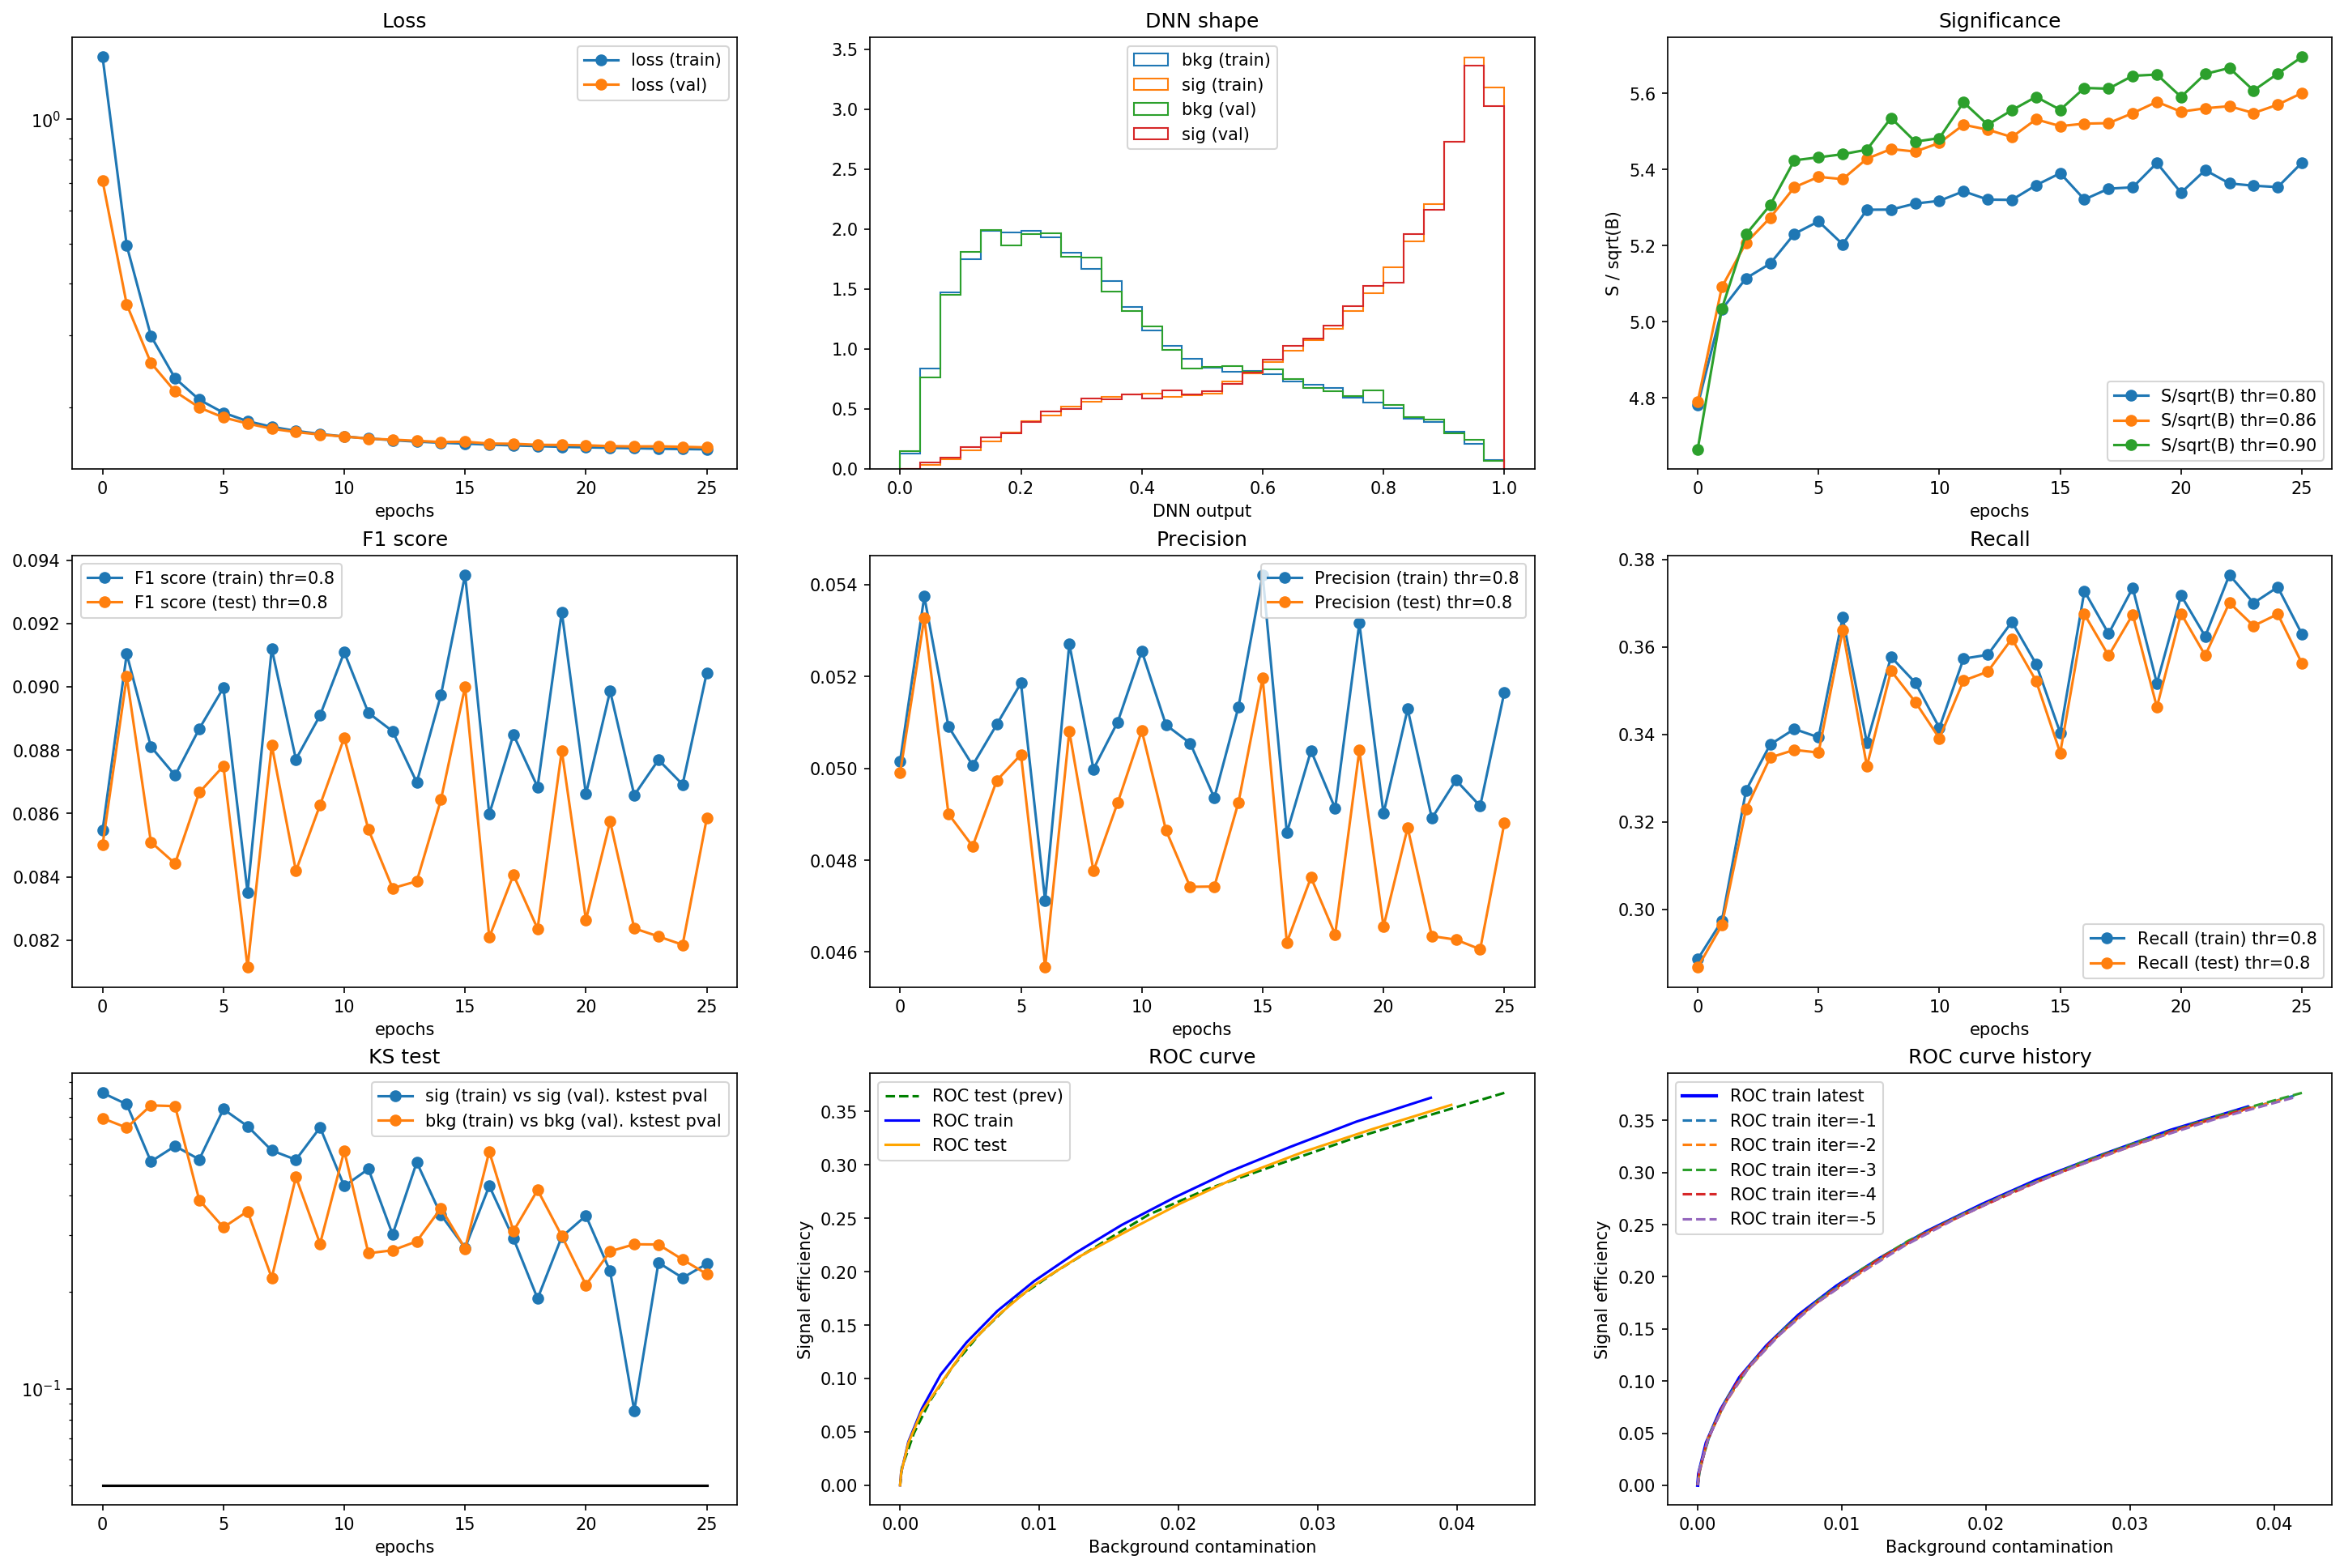

1758820/1758820 [==============================] - 238s 135us/sample - loss: 0.1584 - accuracy: 0.6656 - val_loss: 0.1602 - val_accuracy: 0.6634
Epoch 27/200
 936320/1758820 [==============>...............] - ETA: 1:37 - loss: 0.1578 - accuracy: 0.6664

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [74]:
## TRAINING without random sampling
import time
start_time = time.time()
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=config['patience'][1], patience=config['patience'][0], verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

_callbacks = [plot_losses, early_stopping]


if config['decay_weights'] == 'inverse':
    lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    _callbacks.append(lr_scheduler)
    
if config['decay_weights'] == 'cyclic':
    from callbacks import CyclicLR  
    _callbacks.append(CyclicLR(base_lr=config["decay_weights_pars"][0],
                                max_lr=config["decay_weights_pars"][1],
                                step_size=config["decay_weights_pars"][2],
                                mode="triangular2"))


config["epochs"] = 200

history = model.fit(
            X_train, y_train,
            sample_weight = W_train,
            epochs=config["epochs"],
            validation_data  = (X_test, y_test, W_test),
            callbacks=_callbacks,
            shuffle = True,
            batch_size= config["batch_size"],
            #callbacks = [], 
            #class_weight= {0:1.3,1:1}
             #class_weight= {0:(W[Y==1].sum())/(W[Y==0].sum()),1:1}
        )

config["train_time"] = time.time() - start_time

In [75]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [76]:
args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")


In [77]:
tf.keras.models.save_model(model, model_dir+"/model_output", include_optimizer=False )

INFO:tensorflow:Assets written to: /storage/vbsjjlnu/VBSjjlnu_v7/FullRun2_v7/res_sig/models/v25_e/model_output/assets


In [78]:
plot_losses.save_logs(os.path.join(model_dir, "train_log.csv") )

In [110]:
# inputs:  ['Input']
print('inputs: ', [input.op.name for input in model.inputs])

# outputs:  ['Output/Sigmoid']
print('outputs: ', [output.op.name for output in model.outputs])


outputs = [output.op.name for output in model.outputs]

# save tensorflow metadata
with open(os.path.join(model_dir, "tf_metadata.txt"), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")

inputs:  ['dense_50_input']
outputs:  ['dense_55/Identity']


## Output analysis

### Shap analysis

In [22]:
import shap

shap.initjs()

In [23]:
sample_indexes = np.random.choice(X_scaled.shape[0], 1000, replace=False)
select = np.in1d(range(X_scaled.shape[0]), sample_indexes )  

In [24]:
e = shap.DeepExplainer(model, X_scaled[select])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



keras is no longer supported, please use tf.keras instead.


In [25]:
X = pd.DataFrame(X_scaled[~select][:3000],  columns=config["cols"])
shap_values = e.shap_values(X.values)

ValueError: When eager execution is enabled, use_resource cannot be set to false.

### Columns List

```.python
# resolved
    "cols": [
       "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        #"PuppiMET_pt",
        ###"vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        "vjet_1_pt",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "deltaeta_vjet",
        #"deltaphi_vjet",
        #"deltaR_lep_vbs",
        #"deltaphi_lep_nu",
        #"deltaR_vbs",
        #"deltaR_vjet",
        ###"Zvjets_0",
        #"Zvjets_1",
        "Zlep",
        ####"Asym_vbs",
        #"Mtw_lep",
        #"w_had_pt",
        #"R_mw",
        #"A_ww",
        ####"Centr_vbs",
        "Centr_ww",
        "vbs_0_qgl_res",
        #"vbs_1_qgl_res",
        "vjet_0_qgl_res",
        "vjet_1_qgl_res",
        #"four_tag_jets_HT",
        #"four_tag_jets_pt",
        #"vbs_jets_HT", 
        #"v_jets_HT",
        #"vbs_jets_pt"
         ]

# boosted
    "cols": ['
        "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        "vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        #"vjet_0_eta",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "Zvjets_0",
        "Zlep",
        #"Asym_vbs",
        #"w_lep_pt",
        #"w_had_pt",
        #"A_ww",   #--> togliere
        #"Centr_vbs", #--> togliere
        "Centr_ww",
        #"fatjet_ZvsQCD",
        #"fatjet_WvsQCD",
        #"fatjet_subjet_ptratio",
        #"fatjet_subjet2_pt",
        "vbs_0_qgl_boost",
        #"vbs_1_qgl_boost",
        #"four_tag_jets_HT"
         ]

         
# OLD
    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 'vbs_1_pt', 
             'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 'vjet_1_pt', 
             'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
```